# Sea ice maps for ACCESS-OM2_01
TODO: compare thickness with cryosat data

TODO: code (much) more elegantly

In [1]:
%matplotlib inline
import cosima_cookbook as cc
from dask.distributed import Client
from glob import glob
import os,sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import xarray as xr
import netCDF4 as nc
from tqdm import tqdm_notebook
from mpl_toolkits.basemap import Basemap
from calendar import month_abbr
import cmocean as cm
import pandas as pd
import calendar
from datetime import timedelta
from datetime import datetime
import copy
# import cartopy.crs as ccrs
# import cartopy.feature as cft

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

# set up time units and offset to suit CICE 
# see https://github.com/OceansAus/ACCESS-OM2-1-025-010deg-report/commit/ce3b6331bc4f304d2c5f957ccd2a0ae9ca5d6970#commitcomment-31646163
# for e in exptdata.exptdict.keys():
#     exptdata.exptdict[e]['time_units'] = None

# Set up time_units to suit CICE 
# Only retain netcdf time_units for 0.1 deg.
# We need to change time_units of 1deg and 0.25 deg 
# to shift the time so the last cycle starts in 1958.
# But we don't need offset because CICE time starts at beginning of run, 
# unlike MOM which starts in year 0001.
exptdata.exptdict['01deg']['time_units'] = "days since 1985-01-01"  # don't use None - it leaves the time as cftime

netcdf_index loaded.
Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
exptdata.exptdict

OrderedDict([('1deg',
              {'model': 'access-om2',
               'expt': '1deg_jra55v13_iaf_spinup1_B1',
               'desc': 'ACCESS-OM2',
               'n_files': -12,
               'time_units': 'days since 1718-01-01',
               'offset': -87658,
               'exptdir': '/g/data3/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spinup1_B1'}),
             ('025deg',
              {'model': 'access-om2-025',
               'expt': '025deg_jra55v13_iaf_gmredi6',
               'desc': 'ACCESS-OM2-025',
               'n_files': -34,
               'time_units': 'days since 1718-01-01',
               'offset': -87658,
               'exptdir': '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6'}),
             ('01deg',
              {'model': 'access-om2-01',
               'expt': '01deg_jra55v13_iaf',
               'desc': 'ACCESS-OM2-01',
               'n_files': None,
               'time_units': 'days since 1985-01-01',
               'offset'

## To deal with memory issues (if needed):
* In a terminal on VDI (either over VNC or through SSH and inside screen/tmux), run:
`dask-scheduler`
* This should output the scheduler address, like `tcp://10.0.64.11:8786`. 
* Now, in another terminal (ensuring that the default conda module has cosima_cookbook installed, as all workers will need access to that), run:
`dask-worker tcp://10.0.64.11:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/aek156`
* Then, make sure the following cell matches the scheduler address.

In [3]:
# cc.start_cluster()  # use Client instead?

## Data loading definitions

In [4]:
# cc.build_index(careful=True)
# cc.build_index()

In [5]:
def fixcicetime(da):
    '''
    Correct the time coordinate in DataArray from CICE netcdf file.
    
    CICE netcdf files unhelpfully have a time coordinate which is just after the end of the averaging period, 
    e.g. the time stamp for a January average is 1 February, which messes up groupby month etc.
    
    This function just subtracts 12 hours to put it in the correct month (and day, for daily means).
    
    PR 109 gives an option to fix this:
    https://github.com/OceansAus/cosima-cookbook/pull/109
    
    '''
    try:
        da['time'] = da.time - np.timedelta64(12, 'h')
    except:
        da['time'] = da.time - timedelta(hours=12)  # for 01deg which for some reason uses cftime
    return da

# use this for DataSet: replaces the bad time dimension with the average of time_bounds.
#     The time type is also changed to datetime64[ns]
#     ds['time'] = ds.time_bounds.astype('int64').mean(axis=1).astype('datetime64[ns]')
    

In [6]:
# use common start and end dates for all runs
tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

In [7]:
firstyear = pd.to_datetime(tstart).year  # assumes tstart is 1 January!
lastyear = pd.to_datetime(tend).year-1  # assumes tend is 1 January!
yearrange = str(firstyear)+'-'+str(lastyear)
print(yearrange)
print('tstart = ', tstart)
print('tend = ', tend)

1993-2017
tstart =  1993-01-01 00:00:00
tend =  2018-01-01 00:00:00


In [8]:
def loaddata(ekey, varnames = ['aice_m', 'hi_m', 'hs_m', 'vicen_m']):
# load model data
#   NB: varnames must be t-grid variables
    global ice_data
    try:
        ice_data
    except NameError:
        ice_data = copy.deepcopy(exptdata.exptdict)  # to store ice fields under the same keys as exptdata.exptdict
    ide = ice_data[ekey]
    expt = ide['expt']
    exptdir = ide['exptdir']
    time_units = ide['time_units']
    
    if 'area_t' not in ide.keys():
        # get model grid data from MOM outputs since CICE ones have nans on land
        gridFileList = glob(os.path.join(exptdir, 'output*/ocean/ocean_grid.nc'))
        gridFileList.sort()
        gridfile = xr.open_dataset(gridFileList[0])
        ide['xt_ocean'] = gridfile.xt_ocean.values
        ide['yt_ocean'] = gridfile.yt_ocean.values

        varname = 'area_t'
        var = gridfile[varname]
        ide[varname] = var
        ide[varname+'_NH'] = var.sel(yt_ocean=slice(0, 90))
        ide[varname+'_SH'] = var.sel(yt_ocean=slice(-90,0))

        varname = 'lon_t'
        var = exptdata.joinseams(gridfile.geolon_t, tripole_flip=True, lon=True)
        ide[varname] = var
        ide[varname+'_NH'] = var.sel(yt_ocean=slice(0, 90))
        ide[varname+'_SH'] = var.sel(yt_ocean=slice(-90,0))

        varname = 'lat_t'
        var = exptdata.joinseams(gridfile.geolat_t, tripole_flip=True)
        ide[varname] = var
        ide[varname+'_NH'] = var.sel(yt_ocean=slice(0, 90))
        ide[varname+'_SH'] = var.sel(yt_ocean=slice(-90,0))

    for varname in varnames:
        print(varname)
        if varname not in ide.keys():
            if ekey=='01deg':
                # work around bug: https://github.com/OceansAus/cosima-cookbook/issues/118
                nfiles = len(glob(os.path.join(exptdir, 'output*/ice/OUTPUT/iceh.????-??.nc')))
                tmp1 = cc.get_nc_variable(expt, 'iceh.????-??.nc', varname, time_units=time_units, 
                                     use_cache=use_cache, n=nfiles-200)
                tmp2 = cc.get_nc_variable(expt, 'iceh.????-??.nc', varname, time_units=time_units, 
                                     use_cache=use_cache, n=-200)
                var = fixcicetime(xr.concat([tmp1, tmp2], dim='time'))
            else:
                var = fixcicetime(cc.get_nc_variable(expt, 'iceh.????-??.nc', varname, time_units=time_units, 
                                     use_cache=use_cache, n=-500))
            # use physical coords instead of indices - ASSUMES VARIABLES ARE ON T GRID!
            var.coords['ni'] = ide['xt_ocean']
            var.coords['nj'] = ide['yt_ocean']
            var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
            var = exptdata.joinseams(var)  # NB!
            ide[varname] = var
            ide[varname+'_NH'] = var.sel(yt_ocean=slice(0, 90))
            ide[varname+'_SH'] = var.sel(yt_ocean=slice(-90,0))
            varmm = var.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
            ide[varname+'_monthly_mean'] = varmm
            ide[varname+'_monthly_mean_NH'] = varmm.sel(yt_ocean=slice(0, 90))
            ide[varname+'_monthly_mean_SH'] = varmm.sel(yt_ocean=slice(-90,0))

In [9]:
# Specify paths to observational data

# ObsDir = '/g/data1a/v45/aek156/data/NOAA/G02202_V3'  # from http://nsidc.org/data/G02202
# ObsDirExt = '/g/data1a/v45/aek156/data/NOAA/G02135'  # from http://nsidc.org/data/g02135
ObsDir = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02202_V3'  # from http://nsidc.org/data/G02202
# ObsDirExt = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02135'  # from http://nsidc.org/data/g02135
obsNHFileList = glob(os.path.join(ObsDir, 'north/monthly/*.nc'))
obsSHFileList = glob(os.path.join(ObsDir, 'south/monthly/*.nc'))
# obsExtNHFileList = glob(os.path.join(ObsDirExt, 'north/monthly/data/*.csv'))
# obsExtSHFileList = glob(os.path.join(ObsDirExt, 'south/monthly/data/*.csv'))
obsNHFileList.sort()
obsSHFileList.sort()
# obsExtNHFileList.sort()
# obsExtSHFileList.sort()

In [10]:
def get_obs(obsFileList, years, months, variable='goddard_merged_seaice_conc_monthly'): # seaice_conc_monthly_cdr'): # 
    '''
    Return a dataarray from the nc files in obsFileList.
    Based on get_nc_variable.
                                TODO: fix bug: land mask has white outline - -----------
    '''
    dataarrays = []
    for year in tqdm_notebook(years, leave=False, desc='year'):
        for month in tqdm_notebook(months, leave=False, desc='month'):
            obs_fname = [IceFile for IceFile in obsFileList if IceFile[-16:-10]==str(year)+str(month).zfill(2)][0]
            dataarray = xr.open_dataset(obs_fname,
                                        decode_times=False,
                                        autoclose=True)[variable]
            dataarrays.append(dataarray)
    dataarray = xr.concat(dataarrays, dim='time', coords='all')
    if 'time' in dataarray.coords:
        time_units = dataarray.time.units
        decoded_time = xr.conventions.times.decode_cf_datetime(dataarray.time, time_units)
        dataarray.coords['time'] = ('time', decoded_time,
                                    {'long_name': 'time', 'decoded_using': time_units }
                                   )
    # replace values outside valid range with nan
    dataarray = dataarray.where(xr.ufuncs.logical_and(dataarray>=0,
                                                      dataarray<=1), 
                                np.nan)
# this doesn't work because valid_range is wrong...
#     dataarray = dataarray.where(xr.ufuncs.logical_and(dataarray>=dataarray.valid_range[0],
#                                                       dataarray<=dataarray.valid_range[1]), 
#                                 np.nan)

#     # use lon/lat coords instead of indices - DOESN'T WORK since lon,lat are 2d (actually 3d)
#     dataarray.coords['xgrid'] = dataarray.coords['longitude']
#     dataarray.coords['ygrid'] = dataarray.coords['latitude']
#     dataarray = dataarray.rename(({'xgrid':'xt_ocean', 'ygrid':'yt_ocean'}))

    return dataarray

## Load data

In [11]:
use_cache = True

In [12]:
# save concentration for all resolutions to do extent contours
try:
    ice_data
except NameError:
    ice_data = copy.deepcopy(exptdata.exptdict)  # to store ice fields under the same keys as exptdata.exptdict
for ekey in ice_data.keys():
    loaddata(ekey)

aice_m
Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_B1_iceh.????-??.nc_aice_m_-500_days-since-1718-01-01_None_False.pkl
hi_m
Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_B1_iceh.????-??.nc_hi_m_-500_days-since-1718-01-01_None_False.pkl
hs_m
Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_B1_iceh.????-??.nc_hs_m_-500_days-since-1718-01-01_None_False.pkl
vicen_m
Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_B1_iceh.????-??.nc_vicen_m_-500_days-since-1718-01-01_None_False.pkl
aice_m
Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi6_iceh.????-??.nc_aice_m_-500_days-since-1718-01-01_None_False.pkl
hi_m
Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi6_iceh.????-??.nc_hi_m_-500_days-since-1718-01-01_None_False.pkl
hs_m
Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi6_iceh.????-??.nc_hs_m_-500_days-since-1718-01-01_Non

In [13]:
years = range(firstyear, lastyear+1)
months = range(1,13)

CN_obs_NH = get_obs(obsNHFileList, years, months)
CN_obs_SH = get_obs(obsSHFileList, years, months)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in xarray v0.12. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/xarray/conventions.py:394: SerializationWarning: variable 'melt_onset_day_seaice_conc_monthly_cdr' has multiple fill values {-1, 65535}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in xarray v0.12. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/xarray/conventions.py:394: SerializationWarning: variable 'melt_onset_day_seaice_conc_monthly_cdr' has multiple fill values {-1, 65535}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)


In [14]:
CN_obs_NH_monthly_mean = CN_obs_NH.groupby('time.month').mean('time', skipna=True)
CN_obs_SH_monthly_mean = CN_obs_SH.groupby('time.month').mean('time', skipna=True)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


# Generate plots

In [15]:
figdir = ''
# NOSYNC = '/g/data/v45/aek156/figures/ACCESS-OM2-1-025-010deg-report/figures/ice_validation/NOSYNC/' # where to save figs we don't want to sync
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [16]:
font = {'size':13}
tick_font=12

In [17]:
clevel = 0.15  # extent contour
levels = np.arange(0,1.01,.005)
# cmap_gamma = 4. # exponent for power-law stretch of colormap
# cbar_ticks = [ f**cmap_gamma for f in [0,.5,.6,.7,.8,.85,.9,.95,.98,1] ]  # for cmap_gamma = 4.
cmap_gamma = 2. # exponent for power-law stretch of colormap
cbar_ticks = [ f**cmap_gamma for f in [0,.3,.4,.5,.6,.7,.8,.85,.9,.95,1] ]  # for cmap_gamma = 2.
# cmp = cm.cm.ice
cmp = plt.get_cmap('nipy_spectral')
cmp_div = cm.cm.balance

## Standard model and obs plots

In [18]:
def plot_NH_conc_model(m, xobs, yobs, obs, xys, models, ekey, show_legend=False):
    imodel = list(ice_data.keys()).index(ekey)  # model index
    x, y = xys[imodel]
    model = models[imodel]
#     m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    ctr = m.contourf(x,y,model.sel(yt_ocean=slice(0, 90))**cmap_gamma,levels=levels,cmap=cmp)
    ctr.cmap.set_over(color=cmp(255), alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice concentration',size=tick_font)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
    descs = [d['desc'] for d in ice_data.values()]
    # put obs extent contour under the others
    csobs = m.contour(xobs,yobs,obs,[clevel],colors='white',linewidths=1)
    csobs.collections[0].set_label('Passive microwave '+str(int(clevel*100))+'%')
    for c, ek in enumerate(ice_data.keys()):  # do extent contours for all models
        xx, yy = xys[c]
        d = models[c]
        cs = m.contour(xx,yy,d.sel(yt_ocean=slice(0, 90)),[clevel],colors='C'+str(c),linewidths=1)
        cs.collections[0].set_label(descs[c]+' '+str(int(clevel*100))+'%')
    # put this model's extent contour on top
    cs = m.contour(x,y,model.sel(yt_ocean=slice(0, 90)),[clevel],colors='C'+str(imodel),linewidths=1)

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
    if show_legend:
        plt.legend(prop={'size':8},loc='lower right')

In [19]:
def plot_NH_conc_obs(m, xobs, yobs, obs, xys, models, ekey, show_legend=False):
    imodel = list(ice_data.keys()).index(ekey)  # model index
    x, y = xys[imodel]
    model = models[imodel]
#     m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    ctr = m.contourf(xobs,yobs,obs**cmap_gamma,levels=levels,cmap=cmp)
    ctr.cmap.set_over(color=cmp(255), alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice concentration',size=tick_font)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
    descs = [d['desc'] for d in ice_data.values()]
    for c, ek in enumerate(ice_data.keys()):  # do extent contours for all models
        xx, yy = xys[c]
        d = models[c]
        cs = m.contour(xx,yy,d.sel(yt_ocean=slice(0, 90)),[clevel],colors='C'+str(c),linewidths=1)
        cs.collections[0].set_label(descs[c]+' '+str(int(clevel*100))+'%')
    # put this model's extent contour on top
    cs = m.contour(x,y,model.sel(yt_ocean=slice(0, 90)),[clevel],colors='C'+str(imodel),linewidths=1)
    # put obs extent contour on top
    csobs = m.contour(xobs,yobs,obs,[clevel],colors='white',linewidths=1)
    csobs.collections[0].set_label('Passive microwave '+str(int(clevel*100))+'%')

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
    if show_legend:
        plt.legend(prop={'size':8},loc='lower right')

In [20]:
def plot_SH_conc_model(m, xobs, yobs, obs, xys, models, ekey, show_legend=False):
    imodel = list(ice_data.keys()).index(ekey)  # model index
    x, y = xys[imodel]
    model = models[imodel]
#     m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    ctr = m.contourf(x,y,model.sel(yt_ocean=slice(-90, 0))**cmap_gamma,levels=levels,cmap=cmp)
    ctr.cmap.set_over(color=cmp(255), alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice concentration',size=tick_font)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
    descs = [d['desc'] for d in ice_data.values()]
    # put obs extent contour under the others
    csobs = m.contour(xobs,yobs,obs,[clevel],colors='white',linewidths=1)
    csobs.collections[0].set_label('Passive microwave '+str(int(clevel*100))+'%')
    for c, ek in enumerate(ice_data.keys()):  # do extent contours for all models
        xx, yy = xys[c]
        d = models[c]
        cs = m.contour(xx,yy,d.sel(yt_ocean=slice(-90, 0)),[clevel],colors='C'+str(c),linewidths=1)
        cs.collections[0].set_label(descs[c]+' '+str(int(clevel*100))+'%')
    # put this model's extent contour on top
    cs = m.contour(x,y,model.sel(yt_ocean=slice(-90, 0)),[clevel],colors='C'+str(imodel),linewidths=1)

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
    if show_legend:
        plt.legend(prop={'size':8},loc='center')

In [109]:
def plot_SH_conc_obs(m, xobs, yobs, obs, xys, models, ekey, show_legend=False):
    imodel = list(ice_data.keys()).index(ekey)  # model index
    x, y = xys[imodel]
    model = models[imodel]
#     m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    ctr = m.contourf(xobs,yobs,obs**cmap_gamma,levels=levels,cmap=cmp)
    ctr.cmap.set_over(color=cmp(255), alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice concentration',size=tick_font)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
    descs = [d['desc'] for d in ice_data.values()]
    for c, ek in enumerate(ice_data.keys()):  # do extent contours for all models
        xx, yy = xys[c]
        d = models[c]
        cs = m.contour(xx,yy,d.sel(yt_ocean=slice(-90, 0)),[clevel],colors='C'+str(c),linewidths=1)
        cs.collections[0].set_label(descs[c]+' '+str(int(clevel*100))+'%')
    # put this model's extent contour on top
    cs = m.contour(x,y,model.sel(yt_ocean=slice(-90, 0)),[clevel],colors='C'+str(imodel),linewidths=1)
    # put obs extent contour on top
    csobs = m.contour(xobs,yobs,obs,[clevel],colors='white',linewidths=1)
    csobs.collections[0].set_label('Passive microwave '+str(int(clevel*100))+'%')

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
    if show_legend:
        plt.legend(prop={'size':8},loc='lower right')

## Monthly climatology comparisons

In [22]:
# Arctic ice concentration monthly climatology
def plot_NH_conc_monthly_mean(ekey):
    m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    xys = [m(*(d['lon_t_NH'].data, d['lat_t_NH'].data)) for d in ice_data.values()]
    xobs, yobs = m(*(CN_obs_NH.longitude.isel(time=1).data, CN_obs_NH.latitude.isel(time=1).data))
    for month in months:
        outname = ekey+'_concentration_map_NH_'+yearrange+'_'+str(month).zfill(2)+'_mean'
        if False: #os.path.exists(os.path.join(figdir, outname+'.png')):
            print('Skipping ' + outname + ' (file exists)')
        else:
            print('Doing ' + outname)
            try:
                models = [d['aice_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                obs = CN_obs_NH_monthly_mean.sel(month=month)
            except:
                print('ERROR: could not open files')
                continue
            plt.figure(4,(12,7))
            # plot model
            plt.subplot(1,2,1)
            plot_NH_conc_model(m, xobs, yobs, obs, xys, models, ekey, show_legend=True)
            plt.title(calendar.month_name[month]+' '+yearrange+' mean, ' + exptdata.exptdict[ekey]['desc'], font)
            # plot observations
            ax = plt.subplot(1,2,2)
            plot_NH_conc_obs(m, xobs, yobs, obs, xys, models, ekey, show_legend=False)
            plt.title(calendar.month_name[month]+' '+yearrange+' mean, passive microwave', font) #, y=1.03)
            ax.annotate('NOAA G02202 V3\nPassive microwave\nGoddard merged\nmonthly data',
                xy=(.957, .62), xycoords='figure fraction',
                horizontalalignment='right', verticalalignment='center')
            plt.tight_layout()
            plt.savefig(outname+'.png',dpi=200, bbox_inches="tight")
            plt.close()
#         break

In [23]:
# Antarctic ice concentration monthly climatology
def plot_SH_conc_monthly_mean(ekey):
    m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    xys = [m(*(d['lon_t_SH'].data, d['lat_t_SH'].data)) for d in ice_data.values()]
    xobs, yobs = m(*(CN_obs_SH.longitude.isel(time=1).data, CN_obs_SH.latitude.isel(time=1).data))
    for month in months:
        outname = ekey+'_concentration_map_SH_'+yearrange+'_'+str(month).zfill(2)+'_mean'
        if False: #os.path.exists(os.path.join(figdir, outname+'.png')):
            print('Skipping ' + outname + ' (file exists)')
        else:
            print('Doing ' + outname)
            try:
                models = [d['aice_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                obs = CN_obs_SH_monthly_mean.sel(month=month)
            except:
                print('ERROR: could not open files')
                continue
            plt.figure(4,(12,7))
            # plot model
            plt.subplot(1,2,1)
            plot_SH_conc_model(m, xobs, yobs, obs, xys, models, ekey, show_legend=True)
            plt.title(calendar.month_name[month]+' '+yearrange+' mean, ' + exptdata.exptdict[ekey]['desc'], font)
            # plot observations
            ax = plt.subplot(1,2,2)
            plot_SH_conc_obs(m, xobs, yobs, obs, xys, models, ekey, show_legend=False)
            plt.title(calendar.month_name[month]+' '+yearrange+' mean, passive microwave', font) #, y=1.03)
            ax.annotate('NOAA G02202 V3\nPassive microwave\nGoddard merged\nmonthly data',
                xy=(.5, .5), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center')
            plt.tight_layout()
            plt.savefig(outname+'.png',dpi=200, bbox_inches="tight")
            plt.close()
#         break

1deg
aice_m
hi_m
hs_m
vicen_m
Doing 1deg_concentration_map_NH_1993-2017_01_mean


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Doing 1deg_concentration_map_NH_1993-2017_02_mean
Doing 1deg_concentration_map_NH_1993-2017_03_mean
Doing 1deg_concentration_map_NH_1993-2017_04_mean
Doing 1deg_concentration_map_NH_1993-2017_05_mean
Doing 1deg_concentration_map_NH_1993-2017_06_mean
Doing 1deg_concentration_map_NH_1993-2017_07_mean
Doing 1deg_concentration_map_NH_1993-2017_08_mean
Doing 1deg_concentration_map_NH_1993-2017_09_mean
Doing 1deg_concentration_map_NH_1993-2017_10_mean
Doing 1deg_concentration_map_NH_1993-2017_11_mean
Doing 1deg_concentration_map_NH_1993-2017_12_mean
Doing 1deg_concentration_map_SH_1993-2017_01_mean
Doing 1deg_concentration_map_SH_1993-2017_02_mean
Doing 1deg_concentration_map_SH_1993-2017_03_mean
Doing 1deg_concentration_map_SH_1993-2017_04_mean
Doing 1deg_concentration_map_SH_1993-2017_05_mean
Doing 1deg_concentration_map_SH_1993-2017_06_mean
Doing 1deg_concentration_map_SH_1993-2017_07_mean
Doing 1deg_concentration_map_SH_1993-2017_08_mean
Doing 1deg_concentration_map_SH_1993-2017_09_mean


KeyboardInterrupt: 

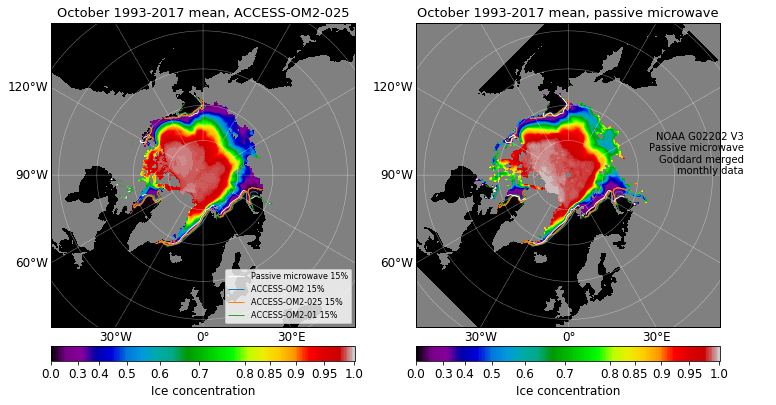

In [24]:
# monthly mean climatology
for ekey in exptdata.exptdict.keys():
    print(ekey)
    loaddata(ekey)
#     plt.figure()
    plot_NH_conc_monthly_mean(ekey)
#     break
#     plt.figure()
    plot_SH_conc_monthly_mean(ekey)
#     break

## Comparisons for individual months

## 4-panel plots for paper
Top row: winter max

Bottom row: summer min

Left col: model

Right col: obs

In [ ]:
# Arctic ice concentration monthly climatology for 4 months
def plot_NH_conc_4_panel(ekey):
    mo = [3, 9]  # specify 2 months (counting from 1) for top and bottom row
    m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    xys = [m(*(d['lon_t_NH'].data, d['lat_t_NH'].data)) for d in ice_data.values()]
    xobs, yobs = m(*(CN_obs_NH.longitude.isel(time=1).data, CN_obs_NH.latitude.isel(time=1).data))
    outname = ekey+'_concentration_map_NH_'+yearrange+'_'+str(mo[0]).zfill(2)+'_'+str(mo[1]).zfill(2)+'_mean'
    if False: #os.path.exists(os.path.join(figdir, outname+'.png')):
        print('Skipping ' + outname + ' (file exists)')
    else:
        print('Doing ' + outname)
        plt.figure(4,(12,10))
        for mi, month in enumerate(mo):
            try:
                models = [d['aice_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                obs = CN_obs_NH_monthly_mean.sel(month=month)
            except:
                print('ERROR: could not open files')
                continue
            # plot model
            plt.subplot(2,2,2*mi+1)
            plot_NH_conc_model(m, xobs, yobs, obs, xys, models, ekey, show_legend=False)
            plt.title('('+str(chr(ord('a')+2*mi))+') '+calendar.month_name[month]+' '+yearrange+' mean, ' + exptdata.exptdict[ekey]['desc'], font)
            # plot observations
            ax = plt.subplot(2,2,2*mi+2)
            plot_NH_conc_obs(m, xobs, yobs, obs, xys, models, ekey, show_legend=mi==1)
            plt.title('('+str(chr(ord('a')+2*mi+1))+') '+calendar.month_name[month]+' '+yearrange+' mean, passive microwave', font) #, y=1.03)
        plt.tight_layout()
        plt.savefig(outname+'.png',dpi=200, bbox_inches="tight")
        plt.close()

In [ ]:
# Antarctic ice concentration monthly climatology for 4 months
def plot_SH_conc_4_panel(ekey):
    mo = [9, 2]  # specify 2 months (counting from 1) for top and bottom row
    m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    xys = [m(*(d['lon_t_SH'].data, d['lat_t_SH'].data)) for d in ice_data.values()]
    xobs, yobs = m(*(CN_obs_SH.longitude.isel(time=1).data, CN_obs_SH.latitude.isel(time=1).data))
    outname = ekey+'_concentration_map_SH_'+yearrange+'_'+str(mo[0]).zfill(2)+'_'+str(mo[1]).zfill(2)+'_mean'
    if False: #os.path.exists(os.path.join(figdir, outname+'.png')):
        print('Skipping ' + outname + ' (file exists)')
    else:
        print('Doing ' + outname)
        plt.figure(4,(12,10))
        for mi, month in enumerate(mo):
            try:
                models = [d['aice_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                obs = CN_obs_SH_monthly_mean.sel(month=month)
            except:
                print('ERROR: could not open files')
                continue
            # plot model
            plt.subplot(2,2,2*mi+1)
            plot_SH_conc_model(m, xobs, yobs, obs, xys, models, ekey, show_legend=False)
            plt.title('('+str(chr(ord('a')+2*mi))+') '+calendar.month_name[month]+' '+yearrange+' mean, ' + exptdata.exptdict[ekey]['desc'], font)
            # plot observations
            ax = plt.subplot(2,2,2*mi+2)
            plot_SH_conc_obs(m, xobs, yobs, obs, xys, models, ekey, show_legend=mi==1)
            plt.title('('+str(chr(ord('a')+2*mi+1))+') '+calendar.month_name[month]+' '+yearrange+' mean, passive microwave', font) #, y=1.03)
        plt.tight_layout()
        plt.savefig(outname+'.png',dpi=200, bbox_inches="tight")
        plt.close()

In [ ]:
for ekey in exptdata.exptdict.keys():
    print(ekey)
    plot_NH_conc_4_panel(ekey)
    plot_SH_conc_4_panel(ekey)

## Monthly climatology bias
INTERPOLATION DOESN'T WORK - xt_ocean, yt_ocean are bogus coords in tripole, and obs coords are in metres

## testing out cartopy - doesn't handle tripole seam....

In [ ]:
ice_data['1deg']['aice_m_monthly_mean'].isel(xt_ocean=slice(0,-1)).isel(yt_ocean=slice(0,-1))

In [ ]:
# testing out cartopy - doesn't handle tripole seam....
plt.figure(figsize=(15,8))
clev = np.arange(0,1.00001,.05)
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',linewidth=0.5)

ax = plt.subplot(2,2,1,projection=ccrs.NorthPolarStereo(central_longitude=-100))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=False)
p1 = ice_data['1deg']['aice_m_monthly_mean'].isel(xt_ocean=slice(0,-1)).isel(yt_ocean=slice(0,-1)).sel(yt_ocean=slice(45, 90)).sel(month=1).plot.contourf(
    cmap=cmp, levels=clev, transform=ccrs.PlateCarree())

ax = plt.subplot(2,2,2,projection=ccrs.NorthPolarStereo(central_longitude=-100))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels=False)
p1 = ice_data['1deg']['aice_m_monthly_mean'].sel(yt_ocean=slice(45, 90)).sel(month=1).plot.contourf(
    cmap=cmp, levels=clev, transform=ccrs.PlateCarree())





## Monthly thickness climatology by category

In [118]:
cmap_gamma = 1
levels_NH = np.arange(0,5.001,.025)
cbar_ticks_NH = np.arange(levels_NH[0], levels_NH[-1]+0.001, 1)

levels_SH = np.arange(0,2.001,.01)
cbar_ticks_SH = np.arange(levels_SH[0], levels_SH[-1]+0.001, 0.25)

# cmp = cm.cm.ice
cmp = plt.get_cmap('nipy_spectral')
cmp_div = cm.cm.balance

In [119]:
def plot_NH_thickness(m, xobs, yobs, obs, xys, aices, models, ekey, c, show_legend=False):
    imodel = list(ice_data.keys()).index(ekey)  # model index
    x, y = xys[imodel]
    model = models[imodel]
    aice = aices[imodel]
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    ctr = m.contourf(x,y,model.sel(nc=c).sel(yt_ocean=slice(0, 90))**cmap_gamma,levels=levels,cmap=cmp,extend='max')
    ctr.cmap.set_over(color=cmp(255), alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice thickness in category '+str(c+1)+' (m)',size=tick_font)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
    descs = [d['desc'] for d in ice_data.values()]
    # put obs extent contour under the others
    csobs = m.contour(xobs,yobs,obs,[clevel],colors='white',linewidths=1)
    csobs.collections[0].set_label('Passive microwave '+str(int(clevel*100))+'%')
    for eki, ek in enumerate([ekey]): #enumerate(ice_data.keys()):  # do extent contours for all models
        xx, yy = xys[eki]
        d = aices[eki]
#         cs = m.contour(xx,yy,d.sel(yt_ocean=slice(0, 90)),[clevel],colors='C'+str(eki),linewidths=1)
        cs = m.contour(xx,yy,d.sel(yt_ocean=slice(0, 90)),[clevel],colors='orange',linewidths=1)
        cs.collections[0].set_label(descs[eki]+' '+str(int(clevel*100))+'%')
    # put this model's extent contour on top
#     cs = m.contour(x,y,aice.sel(yt_ocean=slice(0, 90)),[clevel],colors='C'+str(imodel),linewidths=1)

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
    if show_legend:
        plt.legend(prop={'size':8},loc='right')  # or 'lower right'

In [120]:
def plot_NH_thickness_total(m, xobs, yobs, obs, xys, aices, models, ekey, show_legend=False):
    imodel = list(ice_data.keys()).index(ekey)  # model index
    x, y = xys[imodel]
    model = models[imodel]
    aice = aices[imodel]
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    ctr = m.contourf(x,y,model.sum('nc', skipna=True,min_count=5).sel(yt_ocean=slice(0, 90))**cmap_gamma,levels=levels,cmap=cmp,extend='max')
    ctr.cmap.set_over(color=cmp(255), alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice thickness (m)',size=tick_font)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
    descs = [d['desc'] for d in ice_data.values()]
    # put obs extent contour under the others
    csobs = m.contour(xobs,yobs,obs,[clevel],colors='white',linewidths=1)
    csobs.collections[0].set_label('Passive microwave '+str(int(clevel*100))+'%')
    for eki, ek in enumerate([ekey]): #enumerate(ice_data.keys()):  # do extent contours for all models
        xx, yy = xys[eki]
        d = aices[eki]
#         cs = m.contour(xx,yy,d.sel(yt_ocean=slice(0, 90)),[clevel],colors='C'+str(eki),linewidths=1)
        cs = m.contour(xx,yy,d.sel(yt_ocean=slice(0, 90)),[clevel],colors='orange',linewidths=1)
        cs.collections[0].set_label(descs[eki]+' '+str(int(clevel*100))+'%')
    # put this model's extent contour on top
#     cs = m.contour(x,y,aice.sel(yt_ocean=slice(0, 90)),[clevel],colors='C'+str(imodel),linewidths=1)

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
    if show_legend:
        plt.legend(prop={'size':8},loc='right')  # or 'lower right'

In [121]:
def plot_SH_thickness(m, xobs, yobs, obs, xys, aices, models, ekey, c, show_legend=False):
    imodel = list(ice_data.keys()).index(ekey)  # model index
    x, y = xys[imodel]
    model = models[imodel]
    aice = aices[imodel]
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    ctr = m.contourf(x,y,model.sel(nc=c).sel(yt_ocean=slice(-90, 0))**cmap_gamma,levels=levels,cmap=cmp,extend='max')
    ctr.cmap.set_over(color=cmp(255), alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice thickness in category '+str(c+1)+' (m)',size=tick_font)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
    descs = [d['desc'] for d in ice_data.values()]
    # put obs extent contour under the others
    csobs = m.contour(xobs,yobs,obs,[clevel],colors='white',linewidths=1)
    csobs.collections[0].set_label('Passive microwave '+str(int(clevel*100))+'%')
    for eki, ek in enumerate([ekey]): #enumerate(ice_data.keys()):  # do extent contours for all models
        xx, yy = xys[eki]
        d = aices[eki]
#         cs = m.contour(xx,yy,d.sel(yt_ocean=slice(-90, 0)),[clevel],colors='C'+str(eki),linewidths=1)
        cs = m.contour(xx,yy,d.sel(yt_ocean=slice(-90, 0)),[clevel],colors='orange',linewidths=1)
        cs.collections[0].set_label(descs[eki]+' '+str(int(clevel*100))+'%')
    # put this model's extent contour on top
#     cs = m.contour(x,y,aice.sel(yt_ocean=slice(-90, 0)),[clevel],colors='C'+str(imodel),linewidths=1)

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
    if show_legend:
        plt.legend(prop={'size':8},loc='center')

In [122]:
def plot_SH_thickness_total(m, xobs, yobs, obs, xys, aices, models, ekey, show_legend=False):
    imodel = list(ice_data.keys()).index(ekey)  # model index
    x, y = xys[imodel]
    model = models[imodel]
    aice = aices[imodel]
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    ctr = m.contourf(x,y,model.sum('nc', skipna=True,min_count=5).sel(yt_ocean=slice(-90, 0))**cmap_gamma,levels=levels,cmap=cmp,extend='max')
    ctr.cmap.set_over(color=cmp(255), alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice thickness (m)',size=tick_font)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
    descs = [d['desc'] for d in ice_data.values()]
    # put obs extent contour under the others
    csobs = m.contour(xobs,yobs,obs,[clevel],colors='white',linewidths=1)
    csobs.collections[0].set_label('Passive microwave '+str(int(clevel*100))+'%')
    for eki, ek in enumerate([ekey]): #enumerate(ice_data.keys()):  # do extent contours for all models
        xx, yy = xys[eki]
        d = aices[eki]
#         cs = m.contour(xx,yy,d.sel(yt_ocean=slice(-90, 0)),[clevel],colors='C'+str(eki),linewidths=1)
        cs = m.contour(xx,yy,d.sel(yt_ocean=slice(-90, 0)),[clevel],colors='orange',linewidths=1)
        cs.collections[0].set_label(descs[eki]+' '+str(int(clevel*100))+'%')
    # put this model's extent contour on top
#     cs = m.contour(x,y,aice.sel(yt_ocean=slice(-90, 0)),[clevel],colors='C'+str(imodel),linewidths=1)

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
    if show_legend:
        plt.legend(prop={'size':8},loc='center')

In [123]:
# Arctic ice thickness monthly climatology
def plot_NH_thickness_monthly_mean(ekey):
    m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    xys = [m(*(d['lon_t_NH'].data, d['lat_t_NH'].data)) for d in ice_data.values()]
    xobs, yobs = m(*(CN_obs_NH.longitude.isel(time=1).data, CN_obs_NH.latitude.isel(time=1).data))
    for month in months:
        # total thickness
        outname = ekey+'_thickness_map_NH_'+yearrange+'_'+str(month).zfill(2)+'_mean'
        if False: #os.path.exists(os.path.join(figdir, outname+'.png')):
            print('Skipping ' + outname + ' (file exists)')
        else:
            print('Doing ' + outname)
            try:
                models = [d['vicen_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                aices = [d['aice_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                obs = CN_obs_NH_monthly_mean.sel(month=month)
            except:
                print('ERROR: could not open files')
                continue
            plt.figure(4,(12,7))
            plot_NH_thickness_total(m, xobs, yobs, obs, xys, aices, models, ekey, show_legend=True)
            plt.title(calendar.month_name[month]+' '+yearrange+' mean, ' + exptdata.exptdict[ekey]['desc'], font)
            plt.tight_layout()
            plt.savefig(outname+'.png',dpi=100, bbox_inches="tight")
            plt.close()
#         break

        for c in range(len(ice_data[ekey]['vicen_m_monthly_mean']['nc'])):
            outname = ekey+'_thickness_map_NH_cat'+str(c+1)+'_'+yearrange+'_'+str(month).zfill(2)+'_mean'
            if os.path.exists(os.path.join(figdir, outname+'.png')):
                print('Skipping ' + outname + ' (file exists)')
            else:
                print('Doing ' + outname)
                try:
                    models = [d['vicen_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                    aices = [d['aice_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                    obs = CN_obs_NH_monthly_mean.sel(month=month)
                except:
                    print('ERROR: could not open files')
                    continue
                plt.figure(4,(12,7))
                plot_NH_thickness(m, xobs, yobs, obs, xys, aices, models, ekey, c) #, show_legend=True)
                plt.title(calendar.month_name[month]+' '+yearrange+' mean, ' + exptdata.exptdict[ekey]['desc'], font)
                plt.tight_layout()
                plt.savefig(outname+'.png',dpi=100, bbox_inches="tight")
                plt.close()
#             break
#         break

In [124]:
# Antarctic ice thickness monthly climatology
def plot_SH_thickness_monthly_mean(ekey):
    m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    xys = [m(*(d['lon_t_SH'].data, d['lat_t_SH'].data)) for d in ice_data.values()]
    xobs, yobs = m(*(CN_obs_SH.longitude.isel(time=1).data, CN_obs_SH.latitude.isel(time=1).data))
    for month in months:
        # total thickness
        outname = ekey+'_thickness_map_SH_'+yearrange+'_'+str(month).zfill(2)+'_mean'
        if os.path.exists(os.path.join(figdir, outname+'.png')):
            print('Skipping ' + outname + ' (file exists)')
        else:
            print('Doing ' + outname)
            try:
                models = [d['vicen_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                aices = [d['aice_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                obs = CN_obs_SH_monthly_mean.sel(month=month)
            except:
                print('ERROR: could not open files')
                continue
            plt.figure(4,(12,7))
            plot_SH_thickness_total(m, xobs, yobs, obs, xys, aices, models, ekey, show_legend=True)
            plt.title(calendar.month_name[month]+' '+yearrange+' mean, ' + exptdata.exptdict[ekey]['desc'], font)
            plt.tight_layout()
            plt.savefig(outname+'.png',dpi=100, bbox_inches="tight")
            plt.close()
#         break

        for c in range(len(ice_data[ekey]['vicen_m_monthly_mean']['nc'])):
            outname = ekey+'_thickness_map_SH_cat'+str(c+1)+'_'+yearrange+'_'+str(month).zfill(2)+'_mean'
            if os.path.exists(os.path.join(figdir, outname+'.png')):
                print('Skipping ' + outname + ' (file exists)')
            else:
                print('Doing ' + outname)
                try:
                    models = [d['vicen_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                    aices = [d['aice_m_monthly_mean'].sel(month=month) for d in ice_data.values()]
                    obs = CN_obs_SH_monthly_mean.sel(month=month)
                except:
                    print('ERROR: could not open files')
                    continue
                plt.figure(4,(12,7))
                plot_SH_thickness(m, xobs, yobs, obs, xys, aices, models, ekey, c) #, show_legend=True)
                plt.title(calendar.month_name[month]+' '+yearrange+' mean, ' + exptdata.exptdict[ekey]['desc'], font)
                plt.tight_layout()
                plt.savefig(outname+'.png',dpi=100, bbox_inches="tight")
                plt.close()
#             break
#         break

In [125]:
for ekey in exptdata.exptdict.keys():
#     if ekey=='1deg':
        print(ekey)
        loaddata(ekey)
        levels, cbar_ticks = levels_NH, cbar_ticks_NH
        plot_NH_thickness_monthly_mean(ekey)
        levels, cbar_ticks = levels_SH, cbar_ticks_SH
#         plot_SH_thickness_monthly_mean(ekey)
#         break

1deg
aice_m
hi_m
hs_m
vicen_m
Doing 1deg_thickness_map_NH_1993-2017_01_mean
Skipping 1deg_thickness_map_NH_cat1_1993-2017_01_mean (file exists)
Skipping 1deg_thickness_map_NH_cat2_1993-2017_01_mean (file exists)
Skipping 1deg_thickness_map_NH_cat3_1993-2017_01_mean (file exists)
Skipping 1deg_thickness_map_NH_cat4_1993-2017_01_mean (file exists)
Skipping 1deg_thickness_map_NH_cat5_1993-2017_01_mean (file exists)
Doing 1deg_thickness_map_NH_1993-2017_02_mean
Skipping 1deg_thickness_map_NH_cat1_1993-2017_02_mean (file exists)
Skipping 1deg_thickness_map_NH_cat2_1993-2017_02_mean (file exists)
Skipping 1deg_thickness_map_NH_cat3_1993-2017_02_mean (file exists)
Skipping 1deg_thickness_map_NH_cat4_1993-2017_02_mean (file exists)
Skipping 1deg_thickness_map_NH_cat5_1993-2017_02_mean (file exists)
Doing 1deg_thickness_map_NH_1993-2017_03_mean
Skipping 1deg_thickness_map_NH_cat1_1993-2017_03_mean (file exists)
Skipping 1deg_thickness_map_NH_cat2_1993-2017_03_mean (file exists)
Skipping 1deg_th

Doing 025deg_thickness_map_NH_cat2_1993-2017_12_mean
Doing 025deg_thickness_map_NH_cat3_1993-2017_12_mean
Doing 025deg_thickness_map_NH_cat4_1993-2017_12_mean
Doing 025deg_thickness_map_NH_cat5_1993-2017_12_mean
01deg
aice_m
hi_m
hs_m
vicen_m
Doing 01deg_thickness_map_NH_1993-2017_01_mean
Doing 01deg_thickness_map_NH_cat1_1993-2017_01_mean
Doing 01deg_thickness_map_NH_cat2_1993-2017_01_mean
Doing 01deg_thickness_map_NH_cat3_1993-2017_01_mean
Doing 01deg_thickness_map_NH_cat4_1993-2017_01_mean
Doing 01deg_thickness_map_NH_cat5_1993-2017_01_mean
Doing 01deg_thickness_map_NH_1993-2017_02_mean
Doing 01deg_thickness_map_NH_cat1_1993-2017_02_mean
Doing 01deg_thickness_map_NH_cat2_1993-2017_02_mean
Doing 01deg_thickness_map_NH_cat3_1993-2017_02_mean
Doing 01deg_thickness_map_NH_cat4_1993-2017_02_mean
Doing 01deg_thickness_map_NH_cat5_1993-2017_02_mean
Doing 01deg_thickness_map_NH_1993-2017_03_mean
Doing 01deg_thickness_map_NH_cat1_1993-2017_03_mean
Doing 01deg_thickness_map_NH_cat2_1993-2017_

## Monthly snow thickness climatology

In [ ]:
def plot_NH_snow_thickness(m, x, y, model, model_aice, xobs, yobs, obs):
    model = exptdata.joinseams(model)
    model_aice = exptdata.joinseams(model_aice)
    m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas

    ctr = m.contourf(x,y,model[NLAT_half:,:],levels=np.arange(0,1.01,0.02),cmap=cmp,extend='max')

    ctr.cmap.set_over(color='w', alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Snow thickness (m)',size=tick_font)
    cs = m.contour(x,y,model_aice[NLAT_half:,:],[clevel],colors='g',linewidths=1)
    cs.collections[0].set_label('model '+str(int(clevel*100))+'%')
    cs = m.contour(xobs,yobs,obs,[clevel],colors='r',linewidths=1)
    cs.collections[0].set_label('obs '+str(int(clevel*100))+'%')
    
    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
    plt.legend(prop={'size':11},loc='center right') #, bbox_to_anchor=(1, 1))

In [ ]:
def plot_SH_snow_thickness(m, x, y, model, model_aice, xobs, yobs, obs):
    model = exptdata.joinseams(model)
    model_aice = exptdata.joinseams(model_aice)
    m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas

    ctr = m.contourf(x,y,model[:NLAT_half,:],levels=np.arange(0,1.01,0.02),cmap=cmp,extend='max')

    ctr.cmap.set_over(color='w', alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Snow thickness (m)',size=tick_font)
    cs = m.contour(x,y,model_aice[:NLAT_half,:],[clevel],colors='g',linewidths=1)
    cs.collections[0].set_label('model '+str(int(clevel*100))+'%')
    cs = m.contour(xobs,yobs,obs,[clevel],colors='r',linewidths=1)
    cs.collections[0].set_label('obs '+str(int(clevel*100))+'%')

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
    plt.legend(prop={'size':11},loc='center') #, bbox_to_anchor=(1, 1))

In [ ]:
# Arctic ice snow thickness monthly climatology
def plot_NH_snow_thickness_monthly_mean(ekey):
    m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    x,y = m(*(lon_t[NLAT_half:,:],lat_t[NLAT_half:,:]))
    xobs,yobs = m(*(CN_obs_NH.longitude.isel(time=1).data, CN_obs_NH.latitude.isel(time=1).data))

    for mi, month in enumerate(months):
        outname = ekey+'_snow_thickness_map_NH_'+yearrange+'_'+str(month).zfill(2)+'_mean'
        if os.path.exists(os.path.join(figdir, outname+'.png')):
            print('Skipping ' + outname + ' (file exists)')
        else:
            print('Doing ' + outname)
            try:
                model = hs_m_monthly_mean.sel(month=mi+1)
                model_aice = aice_m_monthly_mean.sel(month=mi+1)
                obs = CN_obs_NH_monthly_mean.sel(month=mi+1)
            except:
                print('ERROR: could not open files')
                continue
            plt.figure(4,(12,7))

            # plot model
            plot_NH_snow_thickness(m, x, y, model, model_aice, xobs, yobs, obs)
            plt.title(calendar.month_name[month]+' '+yearrange+' mean, ' + exptdata.exptdict[ekey]['desc'], font)


            plt.tight_layout()

#             savefigure(outname)
            plt.savefig(outname+'.png',dpi=200, bbox_inches="tight")

            plt.close()

#         break

In [ ]:
# Antarctic ice snow thickness monthly climatology
def plot_SH_snow_thickness_monthly_mean(ekey):
    m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    x,y = m(*(lon_t[:NLAT_half,:],lat_t[:NLAT_half,:]))
    xobs,yobs = m(*(CN_obs_SH.longitude.isel(time=1).data, CN_obs_SH.latitude.isel(time=1).data))

    for mi, month in enumerate(months):
        outname = ekey+'_snow_thickness_map_SH_'+yearrange+'_'+str(month).zfill(2)+'_mean'
        if os.path.exists(os.path.join(figdir, outname+'.png')):
            print('Skipping ' + outname + ' (file exists)')
        else:
            print('Doing ' + outname)
            try:
                model = hs_m_monthly_mean.sel(month=mi+1)
                model_aice = aice_m_monthly_mean.sel(month=mi+1)
                obs = CN_obs_SH_monthly_mean.sel(month=mi+1)
            except:
                print('ERROR: could not open files')
                continue
            plt.figure(4,(12,7))

            # plot model
            plot_SH_snow_thickness(m, x, y, model, model_aice, xobs, yobs, obs)
            plt.title(calendar.month_name[month]+' '+yearrange+' mean, ' + exptdata.exptdict[ekey]['desc'], font)


            plt.tight_layout()

#             savefigure(outname)
            plt.savefig(outname+'.png',dpi=200, bbox_inches="tight")

            plt.close()

#         break

In [ ]:
# monthly mean climatology
for ekey in exptdata.exptdict.keys():
    print(ekey)
    loaddata(ekey)
    plot_NH_snow_thickness_monthly_mean(ekey)
    plot_SH_snow_thickness_monthly_mean(ekey)

In [ ]:
STOPHERE

In [ ]:
aice_m.sel(time=pd.to_datetime('198501', format='%Y%m'))  # BUG: some sort of hashing problem??

# Thickness maps
TODO: redo these as above, and plot for all resolutions

In [ ]:
levels = np.arange(0,5.01,0.1)
cmap_gamma = 1 # exponent for power-law stretch of colormap
cbar_ticks = np.arange(0,5.01,1)
cbar_ticks = [ f**cmap_gamma for f in np.arange(0,5.01,1) ]

In [ ]:
# Arctic ice thickness

m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
x,y = m(*(lon_t[NLAT_half:,:],lat_t[NLAT_half:,:]))
xobs,yobs = m(*(obs_lon_NH,obs_lat_NH))

for yi, year in enumerate(years):
    for mi, month in enumerate(months):
        outnamebase = ekey+'_thickness_map_NH'
        outname = NOSYNC+outnamebase+'/'+outnamebase+'_'+str(year)+'_'+str(month).zfill(2)
        if os.path.exists(os.path.join(figdir, outname+'.png')):
            print('Skipping ' + outname + ' (file exists)')
        else:
            print('Doing ' + outname)
            model = hi_m.sel(time=pd.to_datetime(str(year)+str(month).zfill(2), format='%Y%m'))
            obs = CN_obs_NH[yi*len(months) + mi]
            plt.figure(4,(12,7))

            # plot model
#             plt.subplot(1,2,1)
            m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
            m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
            ctr = m.contourf(x,y,model[NLAT_half:,:]**cmap_gamma,levels=levels,cmap=cmp, extend='max')
            ctr.cmap.set_over(color='w', alpha=None)
            plt.title(calendar.month_name[month]+' '+str(year)+', ' + exptdata.exptdict[ekey]['desc'], font)
            cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
            cbar.set_label('Ice thickness (m)',size=tick_font)
            cbar.set_ticks(cbar_ticks)
            cbar.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
            cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
            plt.setp(cbar_labels,fontsize=tick_font)
            m.contour(x,y,model[NLAT_half:,:],[0.3],colors='g',linewidth=0.5)
            m.contour(xobs,yobs,obs,[0.3],colors='r',linewidth=0.5)
            
            parallels = np.arange(-80.,81,10.)
            # labels = [left,right,top,bottom]
            m.drawparallels(parallels,color='white',linewidth=0.5)#,labels=[False,True,True,False],size=tick_font)
            meridians = np.arange(0.,351.,30.)
            m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)

#             savefigure(outname)
            plt.savefig(outname+'.png',dpi=150, bbox_inches="tight")

            plt.close()

#         break
#     break

In [ ]:
# Antarctic ice thickness

m = Basemap(projection='spstere',boundinglat=-54,lon_0=180,resolution='l') #,round='True')
x,y = m(*(lon_t[:NLAT_half,:],lat_t[:NLAT_half,:]))
xobs,yobs = m(*(obs_lon_SH,obs_lat_SH))

for yi, year in enumerate(years):
    for mi, month in enumerate(months):
        outnamebase = ekey+'_thickness_map_SH'
        outname = NOSYNC+outnamebase+'/'+outnamebase+'_'+str(year)+'_'+str(month).zfill(2)
        if os.path.exists(os.path.join(figdir, outname+'.png')):
            print('Skipping ' + outname + ' (file exists)')
        else:
            print('Doing ' + outname)
            model = hi_m.sel(time=pd.to_datetime(str(year)+str(month).zfill(2), format='%Y%m'))
            obs = CN_obs_SH[yi*len(months) + mi]
            plt.figure(4,(12,7))

            m = Basemap(projection='spstere',boundinglat=-54,lon_0=180,resolution='l') #,round='True')
            m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
            ctr = m.contourf(x,y,model[:NLAT_half,:]**cmap_gamma,levels=levels,cmap=cmp, extend='max')
            ctr.cmap.set_over(color='w', alpha=None)
            plt.title(calendar.month_name[month]+' '+str(year)+', ' + exptdata.exptdict[ekey]['desc'], font)
            cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
            cbar.set_label('Ice  thickness (m)',size=tick_font)
            cbar.set_ticks(cbar_ticks)
            cbar.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
            cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
            plt.setp(cbar_labels,fontsize=tick_font)
            m.contour(x,y,model[:NLAT_half,:],[0.3],colors='g',linewidth=0.5)
            m.contour(xobs,yobs,obs,[0.3],colors='r',linewidth=0.5)
            
            parallels = np.arange(-80.,81,10.)
            # labels = [left,right,top,bottom]
            m.drawparallels(parallels,color='white',linewidth=0.5)#,labels=[False,True,True,False],size=tick_font)
            meridians = np.arange(0.,351.,30.)
            m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)

#             savefigure(outname)
            plt.savefig(outname+'.png',dpi=150, bbox_inches="tight")

            plt.close()

#         break
#     break

In [ ]:
STOPHERE
# old stuff below. try to redo this above using approach in surface_current.ipynb

In [ ]:
aice_m[:NLAT_half,:]

In [ ]:
aice_m_monthly_mean = aice_m.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)



NH_climatology = aice_m_monthly_mean

ice_area_north_climatology = np.zeros(12)

ice_area_south_climatology = np.zeros(12)

In [ ]:
# climatological seasonal cycle of annual sea ice area - take monthly averages of 
# concentration, then sum area where CN > 15%

ice_area_south = []
ice_area_north = []

for IceFile in tqdm_notebook(dataFileList[-n_files:], leave=False):
    ncFile = nc.Dataset(IceFile,'r')
    CN = ncFile.variables['aice_m']
    for month in range(CN.shape[0]):
        area_field = np.ma.where(CN[month,...]>0.15,area_t,0)
        ice_area_south = np.append(ice_area_south,np.sum(area_field[:NLAT_half,...]))
        ice_area_north = np.append(ice_area_north,np.sum(area_field[NLAT_half:,...]))

In [ ]:
# do annual averages:
ice_area_south_climatology = np.zeros(12)
ice_area_north_climatology = np.zeros(12)
for month in range(12):
    ice_area_south_climatology[month] = np.mean(ice_area_south[month::12])
    ice_area_north_climatology[month] = np.mean(ice_area_north[month::12])
# sort months from Jan -> Dec (for model we don't necessarily start with Jan data)
time = ncFile.variables['time']
time_convert = nc.num2date(time[-1],time.units,time.calendar)
last_month = time_convert.month
last_year = time_convert.year
ice_area_south_climatology = np.roll(ice_area_south_climatology,last_month-1)
ice_area_north_climatology = np.roll(ice_area_north_climatology,last_month-1)

ncFile.close()

# Stop here with deliberate error

In [ ]:
STOPHERE

## Climatologies

In [ ]:
############################################
####### obs climatology:
# for obs just use years 1988-1997, because concentration not available before then (*WRONG!*) and 
# climate change after then

# conc_firstyear = 1988
# conc_lastyear  = 1997

conc_firstyear = tclimstart.year
conc_lastyear = tclimend.year-1

# NH All:
# CN_obs_NH = [[] for _ in range(12)]  # list keeps months separate
CN_obs_NH = [None]*12
for mo in tqdm_notebook(range(12), leave=False, desc='month'):  # NB: mo counts from 0
    # length of climatology:
    obs_list = [IceFile for IceFile in obsNHFileList if (IceFile.find(str(mo+1).zfill(2)+'_v0')>0 and 
        IceFile.find('nh_f')>0 and float(IceFile[-16:-12])>=conc_firstyear and \
        float(IceFile[-16:-12])<=conc_lastyear)] 
#     obs_list = [IceFile for IceFile in obsNHFileList if (IceFile.find(str(mo+1).zfill(2)+'_v0')>0 and 
#         IceFile.find('nh_f')>0 and float(IceFile[-16:-12])>1983 and \
#         float(IceFile[-16:-12])<1986)] 

    n_yrs = len(obs_list)
    for IceFile in tqdm_notebook(obs_list, leave=False, desc='year'):
    #     print('opening '+IceFile)
        ncFile = nc.Dataset(IceFile, 'r')
        tmp = ncFile.variables['seaice_conc_monthly_cdr'][0,...]
        if CN_obs_NH[mo] is None:
            CN_obs_NH[mo] = tmp
        else:
            CN_obs_NH[mo] = CN_obs_NH[mo] + tmp
    # divide by n_yrs and mask land / arctic pole hole:
    CN_obs_NH[mo] = np.ma.masked_where(CN_obs_NH[mo]<0,CN_obs_NH[mo]) / n_yrs
    CN_obs_NH[mo] = np.ma.masked_where(CN_obs_NH[mo]>2,CN_obs_NH[mo])
obs_lat_NH = ncFile.variables['latitude'][...]
obs_lon_NH = ncFile.variables['longitude'][...]
ncFile.close()

In [ ]:
obsNHFileList

In [ ]:
# SH All:
CN_obs_SH = [None]*12
for mo in tqdm_notebook(range(12), leave=False, desc='month'):
    # length of climatology:
    obs_list = [IceFile for IceFile in obsSHFileList if (IceFile.find(str(mo+1).zfill(2)+'_v0')>0 and 
        IceFile.find('sh_f')>0 and float(IceFile[-16:-12])>=conc_firstyear and \
        float(IceFile[-16:-12])<=conc_lastyear)] 
    n_yrs = len(obs_list)
    for IceFile in tqdm_notebook(obs_list, leave=False, desc='year'):
    #     print('opening '+IceFile)
        ncFile = nc.Dataset(IceFile,'r')
        tmp = ncFile.variables['seaice_conc_monthly_cdr'][0,...]
        if CN_obs_SH[mo] is None:
            CN_obs_SH[mo] = tmp
        else:
            CN_obs_SH[mo] = CN_obs_SH[mo] + tmp
    # divide by n_yrs and mask land / arctic pole hole:
    CN_obs_SH[mo] = np.ma.masked_where(CN_obs_SH[mo]<0,CN_obs_SH[mo]) / n_yrs
    CN_obs_SH[mo] = np.ma.masked_where(CN_obs_SH[mo]>2,CN_obs_SH[mo])
obs_lat_SH = ncFile.variables['latitude'][...]
obs_lon_SH = ncFile.variables['longitude'][...]
ncFile.close()

In [ ]:
# monthly ice concentration climatologies

CN_Feb = 0
CN_Mar = 0
CN_Sep = 0

CN_Sep_years = [[] for _ in range(n_years)]

# Feb (Antarctic only)
for IceFile in [f for f in dataFileList[firstfile:firstfile+n_files] if f.endswith('-02.nc')]:
#     print('opening '+IceFile)
    ncFile = nc.Dataset(IceFile,'r')
    CN_Feb = CN_Feb + ncFile.variables['aice_m'][0,:NLAT_half,:]

# March (Arctic only)
for IceFile in [f for f in dataFileList[firstfile:firstfile+n_files] if f.endswith('-03.nc')]:
#     print('opening '+IceFile)
    ncFile = nc.Dataset(IceFile,'r')
    CN_Mar = CN_Mar + ncFile.variables['aice_m'][0,NLAT_half:,:]

# Sep (both)
for n,IceFile in enumerate([f for f in dataFileList[firstfile:firstfile+n_files] if f.endswith('-09.nc')]):
#     print('opening '+IceFile)
    ncFile = nc.Dataset(IceFile,'r')
#     CN_Sep_years[n] = np.append(CN_Sep_years, ncFile.variables['aice_m'][0,:,:])
    CN_Sep_years[n] = ncFile.variables['aice_m'][0,:,:]
    CN_Sep = CN_Sep + CN_Sep_years[n]
    CN_Sep_years[n] = np.ma.masked_where(land_mask==1,CN_Sep_years[n])

# divide by n_years and mask:
CN_Feb = np.ma.masked_where(land_mask[:NLAT_half,:]==1,CN_Feb / n_years)
CN_Mar = np.ma.masked_where(land_mask[NLAT_half:,:]==1,CN_Mar / n_years)
CN_Sep = np.ma.masked_where(land_mask==1,CN_Sep / n_years)
ncFile.close()

In [ ]:
levels = np.arange(0,1.01,.01)
font = {'size':13}
tick_font=13

### Arctic model concentration maps, Sept and March

In [ ]:
plt.figure(4,(12,7))
plt.clf()

plt.subplot(1,2,1)
m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
x,y = m(*(lon_t[NLAT_half:,:],lat_t[NLAT_half:,:]))
xobs,yobs = m(*(obs_lon_NH,obs_lat_NH))
ctr = m.contourf(x,y,CN_Sep[NLAT_half:,:],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('September min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('September min',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
m.contour(x,y,CN_Sep[NLAT_half:,:],[0.3],colors='w')
# obs:
# m.contour(xobs,yobs,CN_obs_Sep_NH,[0.3],colors='r')
m.contour(xobs,yobs,CN_obs_NH[9-1],[0.3],colors='r')


plt.subplot(1,2,2)
m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
ctr = m.contourf(x,y,CN_Mar,levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('March max, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('March max',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
m.contour(x,y,CN_Mar,[0.3],colors='w')
# obs:
# m.contour(xobs,yobs,CN_obs_Mar_NH,[0.3],colors='r')
m.contour(xobs,yobs,CN_obs_NH[3-1],[0.3],colors='r')


plt.tight_layout()

# savefigure('Arctic_concentration_map')

### Arctic model and obs concentration maps, Sept

In [ ]:
plt.figure(4,(12,7))
plt.clf()

plt.subplot(1,2,1)
m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
x,y = m(*(lon_t[NLAT_half:,:],lat_t[NLAT_half:,:]))
xobs,yobs = m(*(obs_lon_NH,obs_lat_NH))
ctr = m.contourf(x,y,CN_Sep[NLAT_half:,:],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('September min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('September min, model',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
m.contour(x,y,CN_Sep[NLAT_half:,:],[0.3],colors='w')
# obs:
# m.contour(xobs,yobs,CN_obs_Sep_NH,[0.3],colors='r')
m.contour(xobs,yobs,CN_obs_NH[9-1],[0.3],colors='r')


plt.subplot(1,2,2)
m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
ctr = m.contourf(xobs,yobs,CN_obs_NH[9-1],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('March max, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('September min, obs',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
m.contour(x,y,CN_Sep[NLAT_half:,:],[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_NH[9-1],[0.3],colors='r')

plt.tight_layout()

# savefigure('Arctic_concentration_map_Sep')

In [ ]:
plt.figure(4,(12,7*n_years))
plt.clf()

# TODO: check that the CN_Sep_years list elements are not identical

for n in tqdm_notebook(range(n_years), leave=False):
    year = int(int(total_years)-n_years+n+1)
    plt.subplot(n_years,1,n+1)
    m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    x,y = m(*(lon_t[NLAT_half:,:],lat_t[NLAT_half:,:]))
    xobs,yobs = m(*(obs_lon_NH,obs_lat_NH))
    ctr = m.contourf(x,y,CN_Sep_years[n][NLAT_half:,:],levels=levels,cmap='viridis', extend='max')
    ctr.cmap.set_over(color='w', alpha=None)
    # plt.title('September min, yrs '+str(last_year-(n_years-1))+'-'+
    # 	str(last_year),font,y=1.03)
    plt.title('September, year '+str(year),font,y=1.03)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice concentration',size=tick_font)
    cbar.set_ticks([0,.2,.4,.6,.8,1])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
    #m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
    m.contour(x,y,CN_Sep_years[n][NLAT_half:,:],[0.3],colors='w')
    # obs:
#     m.contour(xobs,yobs,CN_obs_Sep_NH,[0.3],colors='r')
    m.contour(xobs,yobs,CN_obs_NH[9-1],[0.3],colors='r')

### Arctic model and obs concentration maps, March

In [ ]:
plt.figure(4,(12,7))
plt.clf()

plt.subplot(1,2,1)
m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
x,y = m(*(lon_t[NLAT_half:,:],lat_t[NLAT_half:,:]))
xobs,yobs = m(*(obs_lon_NH,obs_lat_NH))
ctr = m.contourf(x,y,CN_Mar,levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('September min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('March max, model',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
m.contour(x,y,CN_Mar,[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_NH[3-1],[0.3],colors='r')

plt.subplot(1,2,2)
m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
ctr = m.contourf(xobs,yobs,CN_obs_NH[3-1],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('March max, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('March max, obs',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
m.contour(x,y,CN_Mar,[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_NH[3-1],[0.3],colors='r')

plt.tight_layout()

# savefigure('Arctic_concentration_map_Mar')

### Antarctic model and obs concentration maps

In [ ]:
plt.figure(3,(12,7))
plt.clf()

plt.subplot(1,2,1)
m = Basemap(projection ='spstere',boundinglat=-50,lon_0=180,resolution='l',round='True')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
x,y = m(*(lon_t[:NLAT_half,:],lat_t[:NLAT_half,:]))
xobs,yobs = m(*(obs_lon_SH,obs_lat_SH))
ctr = m.contourf(x,y,CN_Feb,levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('February min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('February min',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[:NLAT_half,:],[0,1],colors='w')
m.contour(x,y,CN_Feb,[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_SH[2-1],[0.3],colors='r')

plt.subplot(1,2,2)
m = Basemap(projection ='spstere',boundinglat=-50,lon_0=180,resolution='l',round='True')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
ctr = m.contourf(x,y,CN_Sep[:NLAT_half,:],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('September max, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('September max',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[:NLAT_half,:],[0,1],colors='w')
m.contour(x,y,CN_Sep[:NLAT_half,:],[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_SH[9-1],[0.3],colors='r')

plt.tight_layout()

# savefigure('Antarctic_concentration_map')

### Antarctic model and obs concentration maps, Feb

In [ ]:
plt.figure(4,(12,7))
plt.clf()

plt.subplot(1,2,1)
m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
x,y = m(*(lon_t[:NLAT_half,:],lat_t[:NLAT_half,:]))
xobs,yobs = m(*(obs_lon_SH,obs_lat_SH))
ctr = m.contourf(x,y,CN_Feb,levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='y', alpha=None)
# plt.title('September min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('February min, model',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[:NLAT_half,:],[0,1],colors='w')
m.contour(x,y,CN_Feb,[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_SH[3-1],[0.3],colors='r')

plt.subplot(1,2,2)
m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
ctr = m.contourf(xobs,yobs,CN_obs_SH[3-1],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='y', alpha=None)
# plt.title('February min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('February min, obs',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[:NLAT_half,:],[0,1],colors='w')
m.contour(x,y,CN_Feb,[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_SH[3-1],[0.3],colors='r')

plt.tight_layout()

# savefigure('Antarctic_concentration_map_Feb')

### Antarctic model and obs concentration maps, Sep

In [ ]:
plt.figure(4,(12,7))
plt.clf()

plt.subplot(1,2,1)
m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
x,y = m(*(lon_t[:NLAT_half,:],lat_t[:NLAT_half,:]))
xobs,yobs = m(*(obs_lon_SH,obs_lat_SH))
ctr = m.contourf(x,y,CN_Sep[:NLAT_half,:],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='y', alpha=None)
# plt.title('September min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('September max, model',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[:NLAT_half,:],[0,1],colors='w')
m.contour(x,y,CN_Sep[:NLAT_half,:],[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_SH[9-1],[0.3],colors='r')

plt.subplot(1,2,2)
m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
ctr = m.contourf(xobs,yobs,CN_obs_SH[9-1],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='y', alpha=None)
# plt.title('September max, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('September max, obs',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[:NLAT_half,:],[0,1],colors='w')
m.contour(x,y,CN_Sep[:NLAT_half,:],[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_SH[9-1],[0.3],colors='r')

plt.tight_layout()

# savefigure('Antarctic_concentration_map_Sep')

## Thickness maps